Files in /content:
 ['.config', 'fuel efficiency.csv', 'sample_data']

Dataset Preview:
                 모델명                            제조(수입사)   차종   유형 복합_연비  \
0           베프(VEV)  Luqi Intellgent Technology Co Ltd  화물차  일반형     6   
1      MASADA QQ 2밴                              체리자동차  화물차   밴형   6.3   
2  CEVO-C SE 1인승 밴형                        주식회사 쎄보모빌리티  승용차  일반형   6.3   
3               포텐스                          (주)진우에스엠씨  화물차  일반형   4.5   
4        D2C(D2C13)                              쎄미시스코  화물차   화물   5.4   

   1회충전주행거리 도심_연비 고속도로_연비   등급  
0      67.0   5.9     6.2  초소형  
1     100.0   6.4     6.1  초소형  
2      69.0   6.7     5.8  초소형  
3      57.0   5.4     3.8  초소형  
4      79.0     6     4.8  초소형  


/tmp/ipython-input-2524807331.py:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')



Categorical: ['모델명', '제조(수입사)', '차종', '유형', '도심_연비', '고속도로_연비', '등급']
Numerical: ['1회충전주행거리']


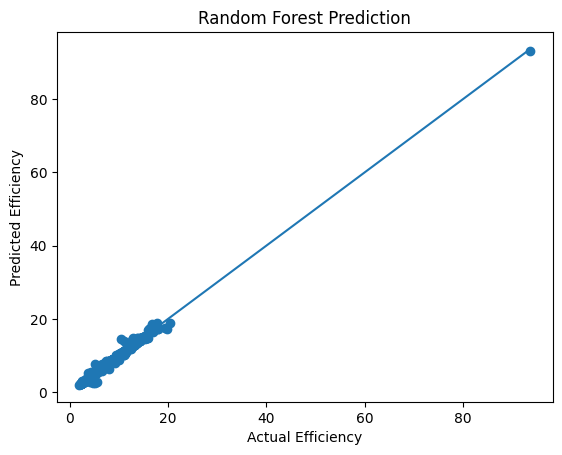

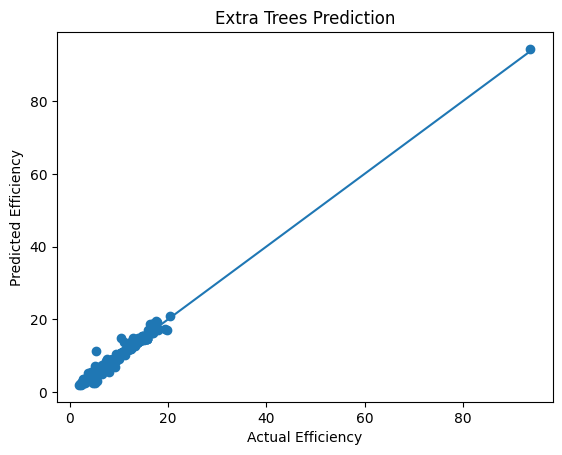


Model Performance:

           Model       MSE      RMSE       MAE  R2 Score
0  Random Forest  0.178432  0.422412  0.187308  0.991572
1    Extra Trees  0.242746  0.492693  0.185960  0.988534


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------
# 1. LOAD DATA
# -------------------------

print("Files in /content:\n", os.listdir("/content"))

df = pd.read_csv("/content/fuel efficiency.csv")

df = df.dropna(axis=1, how='all')

print("\nDataset Preview:\n", df.head())

# -------------------------
# 2. CLEAN COLUMNS WITH "x / y"
# -------------------------

for col in df.columns:
    if df[col].dtype == object:
        # convert values like "2.9 / 10.7" → 2.9
        df[col] = df[col].astype(str).str.split('/').str[0].str.strip()

# try converting numeric columns again
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

# -------------------------
# 3. TARGET COLUMN
# -------------------------

target_col = "복합_연비"   # fuel efficiency

y = df[target_col]
X = df.drop(target_col, axis=1)

# -------------------------
# 4. COLUMN TYPES
# -------------------------

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("\nCategorical:", categorical_cols)
print("Numerical:", numerical_cols)

# -------------------------
# 5. PREPROCESSING
# -------------------------

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# -------------------------
# 6. TRAIN TEST SPLIT
# -------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------
# 7. MODELS
# -------------------------

models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42)
}

# -------------------------
# 8. TRAIN & EVALUATE
# -------------------------

results = []

for name, model in models.items():

    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, mse, rmse, mae, r2])

    # Scatter plot
    plt.figure()
    plt.scatter(y_test, preds)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()])
    plt.xlabel("Actual Efficiency")
    plt.ylabel("Predicted Efficiency")
    plt.title(f"{name} Prediction")
    plt.show()

# -------------------------
# 9. RESULTS
# -------------------------

results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "MAE", "R2 Score"])

print("\nModel Performance:\n")
print(results_df)


In [10]:
from sklearn.metrics import mean_absolute_percentage_error


In [12]:
results_df = pd.DataFrame(
    results,
    columns=["Model", "MSE", "RMSE", "MAE", "R2 Score", "MAPE", "Accuracy (%)"]
)

print("\nModel Performance:\n")
print(results_df)



Model Performance:

           Model       MSE      RMSE       MAE  R2 Score      MAPE  \
0  Random Forest  0.178432  0.422412  0.187308  0.991572  0.021936   
1    Extra Trees  0.242746  0.492693  0.185960  0.988534  0.022415   

   Accuracy (%)  
0     97.806385  
1     97.758508  


In [17]:
mape = mean_absolute_percentage_error(y_test, preds)

accuracy = 100 - (mape * 100)
